In [2]:
pip install --upgrade scikit-learn imbalanced-learn

In [ ]:
pip install scikit-learn==<specific_version>

zsh:1: parse error near `>'


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install imbalanced-learn==<specific_version>

zsh:1: parse error near `>'
Note: you may need to restart the kernel to use updated packages.


# INSY695-078 Final Project: Analysis of Hotel Booking Cancellations

End to end project using Predictive Modeling and Causal Inference for Hotel Booking Cancellation Insights

## 1. Import the Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import xgboost as xgb
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import *
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import RandomOverSampler
import joblib

import warnings
warnings.filterwarnings('ignore')

## 2. Data Preprocessing

In [2]:
# Load the data
df = pd.read_csv('/Users/zy/Documents/GitHub/hotel_cancellation_ML2/Part 1/hotel_booking.csv')

### 2.1 Feature Engineering

In [3]:
df.sort_values(by=['name', 'arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'], inplace=True)

# Create Number of bookings column counting the number of bookings by name prior to arrival year, month and day
df['num_bookings'] = df.groupby('name').cumcount()

# Arrival date year does not make sense for the model we want to build, so we drop it
df = df.drop(['arrival_date_year'], axis=1)

# Keep country names with more than 1000 bookings rest as 'Other'   
country_counts = df['country'].value_counts()
df['country'] = np.where(df['country'].isin(country_counts.index[country_counts > 1000]), df['country'], 'Other')

### 2.2 Reservation Status, Reservation Status Date are Updated after is cancelled , so it is dropped

In [4]:
# Drop the 'reservation_status_date' and 'reservation_status_days_difference' columns
df = df.drop(['reservation_status_date', 'reservation_status','assigned_room_type'], axis=1)

### 2.3 Removing Personal identification information

In [5]:
df = df.drop(['name', 'email','phone-number', 'credit_card'], axis=1)

### 2.4 Since the number of agents and company is very high and there are many missing values, we can omit these columns

In [6]:
# Drop the 'agent' and 'company' columns
df = df.drop(['agent', 'company'], axis=1)

### 2.5 Replace missing values with the 0 for the children column


In [7]:
df['children'] = df['children'].fillna(0)

## 3. Split the Data into train, validation, and test set

In [8]:
train, eval = train_test_split(df, test_size=0.3, random_state=42)
test, val = train_test_split(eval, test_size=0.5, random_state=42)

## 4. Categorical Encoding

In [9]:
# Using get_dummies to convert categorical columns to numerical columns
train = pd.get_dummies(train, columns=['hotel','arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'], drop_first=True)

## 5. Handling Outliers in the dataset

In [10]:
iforest = IsolationForest(n_estimators=100, random_state=42, contamination=0.02)
pred = iforest.fit_predict(train)
score = iforest.decision_function(train)

from numpy import where
anom_index = where(pred== -1)
values = train.iloc[anom_index]

#Remove outliers
train = train.drop(values.index)

## 6. Define the target and features

In [11]:
# Split the data into features and target
X_train = train.drop('is_canceled', axis=1)
y_train = train['is_canceled']

## 7. Feature Selection

In [12]:
randomforest = RandomForestClassifier(random_state=42)
model = randomforest.fit(X_train,y_train)
model.feature_importances_
pd.DataFrame(list(zip(X_train.columns,model.feature_importances_)), columns = ['predictor','feature importance']).sort_values("feature importance")[:10]

,predictor,feature importance
54,market_segment_Undefined,0.000012
58,distribution_channel_Undefined,0.000018
66,reserved_room_type_L,0.000037
69,deposit_type_Refundable,0.000135
67,reserved_room_type_P,0.000181
56,distribution_channel_GDS,0.000230
70,customer_type_Group,0.000233
48,market_segment_Complementary,0.000416
65,reserved_room_type_H,0.000594
7,babies,0.000801


In [13]:
#Drop columns with low feature importance 'reserved_room_type_L','market_segment_Undefined','distribution_channel_Undefined'
X_train = X_train.drop(['reserved_room_type_L','market_segment_Undefined','distribution_channel_Undefined'], axis=1)

## 8. Standardize the Data

In [14]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

## 9. Preprocessing for Validation & Test Data

In [15]:
#Replace missing values with the 0 for the children column
val['children'] = val['children'].fillna(0)

# Using get_dummies to convert categorical columns to numerical columns
val = pd.get_dummies(val, columns=['hotel','arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'], drop_first=True)

# Split the data into features and target
X_val = val.drop('is_canceled', axis=1)
y_val = val['is_canceled']

#Drop columns with low feature importance 'reserved_room_type_L','market_segment_Undefined','distribution_channel_Undefined' if these columns exist
if 'reserved_room_type_L' in X_val.columns:
    X_val = X_val.drop(['reserved_room_type_L'], axis=1)
if 'market_segment_Undefined' in X_val.columns:
    X_val = X_val.drop(['market_segment_Undefined'], axis=1)
if 'distribution_channel_Undefined' in X_val.columns:
    X_val = X_val.drop(['distribution_channel_Undefined'], axis=1)

#standardize the data
sc = StandardScaler()
X_val_std = sc.fit_transform(X_val)


#Replace missing values with the 0 for the children column
test['children'] = test['children'].fillna(0)

# Using get_dummies to convert categorical columns to numerical columns
test = pd.get_dummies(test, columns=['hotel','arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type'], drop_first=True)

# Split the data into features and target
X_test = test.drop('is_canceled', axis=1)
y_test = test['is_canceled']

#Drop columns with low feature importance 'reserved_room_type_L','market_segment_Undefined','distribution_channel_Undefined' if these columns exist
if 'reserved_room_type_L' in X_test.columns:
    X_test = X_test.drop(['reserved_room_type_L'], axis=1)
if 'market_segment_Undefined' in X_test.columns:
    X_test = X_test.drop(['market_segment_Undefined'], axis=1)
if 'distribution_channel_Undefined' in X_test.columns:
    X_test = X_test.drop(['distribution_channel_Undefined'], axis=1)

#standardize the data
sc = StandardScaler()
X_test_std = sc.fit_transform(X_test)

## 10. Balancing the Classes for training data

In [16]:
#Use RandomOverSampler to handle imbalanced data
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train_std, y_train)

pd.Series(y_train_ros).value_counts()

0    51281
1    51281
Name: is_canceled, dtype: int64

In [17]:
train_X = X_train.copy()
cols = list(train_X)

X_train_ros=pd.DataFrame(X_train_ros)
X_train_ros.columns=cols
#Renaming column name of Target variable
y_train_ros=pd.DataFrame(y_train_ros)
y_train_ros.columns = ['is_canceled']
scaled_train_df = pd.concat([X_train_ros,y_train_ros], axis=1)

X_train_ros & y_train_ros are the final features and target dataframes after balancing classes to be used for model training.

## 11. Training for the best selected model (from Part I)

In [ ]:
clf_rf_best = RandomForestClassifier(
    **{
        "min_samples_leaf": 1,
        "n_estimators": 200,
        "random_state": 42,
    })
clf_rf_best.fit(X_train_ros, y_train_ros)
print("Accuracy score of the best model: ", accuracy_score(y_val, clf_rf_best.predict(X_val)))
print("\nROC-AUC score of the best model: ", roc_auc_score(y_val, clf_rf_best.predict(X_val)))

Accuracy score of the best model:  0.6282316153889106

ROC-AUC score of the best model:  0.6514754434856518


## 12. Hyperparameter Tuning

In [18]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from bayes_opt import BayesianOptimization
from ray.tune.schedulers import PopulationBasedTraining
from ray import tune

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray.tune.schedulers import HyperBandForBOHB
import mlflow

from sklearn.model_selection import cross_val_predict

#### Function for ROC-AUC plots

In [38]:
# Define the plot_roc_curve function
def plot_roc_curve(y_true, y_pred_proba, title='ROC Curve'):
    """
    Plot ROC curve given true labels and predicted probabilities.
    
    Parameters:
    - y_true: array-like, true binary labels (0 or 1)
    - y_pred_proba: array-like, predicted probabilities of positive class
    - title: str, title of the plot (default: 'ROC Curve')
    
    Returns:
    - None
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

### 12.1 Bayesian Optimization

In [20]:
'''best_params_bayesian = {'max_depth': 30,
                        'max_features': 1,
                        'min_samples_leaf': 1,
                        'min_samples_split': 2,
                        'n_estimators': 201}

best_rf_bayes = RandomForestClassifier(**best_params_bayesian, random_state=42)
best_rf_bayes.fit(X_train_ros, y_train_ros)

y_pred_val_bayes = best_rf_bayes.predict(X_val)
accuracy_val_bayes = accuracy_score(y_val, y_pred_val_bayes)

y_pred_proba_val_bayes = best_rf_bayes.predict_proba(X_val)[:, 1]
roc_auc_val_bayes = roc_auc_score(y_val, y_pred_val_bayes)

# Print the accuracy and ROC-AUC score
print("Bayesian Optimization:")
print("Best Accuracy:", accuracy_val_bayes)
print("Best ROC-AUC Score:", roc_auc_val_bayes)

plot_bayes = plot_roc_curve(y_val, y_pred_proba_val_bayes, title='Bayesian Optimization')
plot_bayes'''

'best_params_bayesian = {\'max_depth\': 30,\n                        \'max_features\': 1,\n                        \'min_samples_leaf\': 1,\n                        \'min_samples_split\': 2,\n                        \'n_estimators\': 201}\n\nbest_rf_bayes = RandomForestClassifier(**best_params_bayesian, random_state=42)\nbest_rf_bayes.fit(X_train_ros, y_train_ros)\n\ny_pred_val_bayes = best_rf_bayes.predict(X_val)\naccuracy_val_bayes = accuracy_score(y_val, y_pred_val_bayes)\n\ny_pred_proba_val_bayes = best_rf_bayes.predict_proba(X_val)[:, 1]\nroc_auc_val_bayes = roc_auc_score(y_val, y_pred_val_bayes)\n\n# Print the accuracy and ROC-AUC score\nprint("Bayesian Optimization:")\nprint("Best Accuracy:", accuracy_val_bayes)\nprint("Best ROC-AUC Score:", roc_auc_val_bayes)\n\nplot_bayes = plot_roc_curve(y_val, y_pred_proba_val_bayes, title=\'Bayesian Optimization\')\nplot_bayes'

In [21]:
best_params_bayesian = {'max_depth': 30,
                        'max_features': 1,
                        'min_samples_leaf': 1,
                        'min_samples_split': 2,
                        'n_estimators': 201}

best_rf_bayes = RandomForestClassifier(**best_params_bayesian, random_state=42)
best_rf_bayes.fit(X_train_ros, y_train_ros)

# Evaluate the model using cross-validation
accuracy_scores_bayes = cross_val_score(best_rf_bayes, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
roc_auc_scores_bayes = cross_val_score(best_rf_bayes, X_train_ros, y_train_ros, cv=5, scoring='roc_auc')

print('Bayesian Optimization:')
print('Accuracy: ', np.mean(accuracy_scores_bayes))
print('ROC-AUC: ', np.mean(roc_auc_scores_bayes))

Bayesian Optimization:
Accuracy:  0.9151346168895749
ROC-AUC:  0.972700833843081


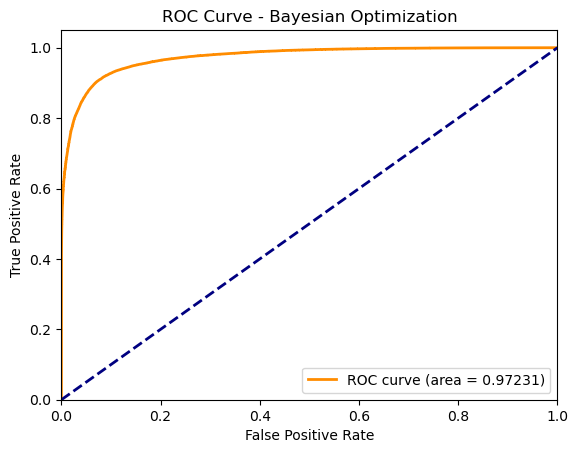

In [34]:
# Obtain cross-validated predicted class labels
y_pred_cv_bayes = cross_val_predict(best_rf_bayes, X_train_ros, y_train_ros, cv=5)

# Initialize an array to store predicted probabilities
y_pred_proba_cv_bayes = np.zeros_like(y_pred_cv_bayes, dtype=float)

skf = StratifiedKFold(n_splits=5)

# Calculate probabilities manually
for train_index, test_index in skf.split(X_train_ros, y_train_ros):
    X_train_fold, X_test_fold = X_train_ros.iloc[train_index], X_train_ros.iloc[test_index]
    y_train_fold, y_test_fold = y_train_ros.iloc[train_index], y_train_ros.iloc[test_index]
    
    clf = RandomForestClassifier(**best_params_bayesian, random_state=42)
    clf.fit(X_train_fold, y_train_fold)
    
    probas = clf.predict_proba(X_test_fold)
    y_pred_proba_cv_bayes[test_index] = probas[:, 1]  # Store probabilities for the positive class

# Plot ROC curve
plot_bayes = plot_roc_curve(y_train_ros, y_pred_proba_cv_bayes, title='Bayesian Optimization')
plot_bayes

### 12.2 TPE Optimization

In [35]:
# TPE Optimization
best_params_tpe = {'max_depth': None,
                   'max_features': 0.23633466511884305,
                   'min_samples_leaf': 0.00000000000000000000000000000000000000000000000001,
                   'min_samples_split': 0.00000000000000000000000000000000000000000000000001,
                   'n_estimators': 2}

best_rf_tpe = RandomForestClassifier(**best_params_tpe, random_state=42)
best_rf_tpe.fit(X_train_ros, y_train_ros)

# Evaluate the model using cross-validation
accuracy_scores_tpe = cross_val_score(best_rf_tpe, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
roc_auc_scores_tpe = cross_val_score(best_rf_tpe, X_train_ros, y_train_ros, cv=5, scoring='roc_auc')

print('TPE:')
print('Accuracy: ', np.mean(accuracy_scores_tpe))
print('ROC-AUC: ', np.mean(roc_auc_scores_tpe))

TPE:
Accuracy:  0.8770406231108113
ROC-AUC:  0.9229551181653914


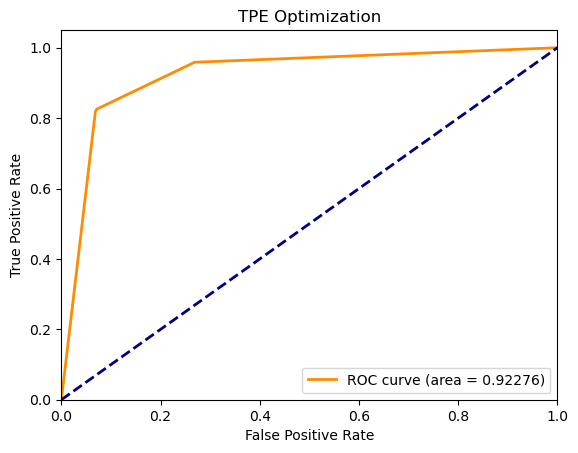

In [39]:
# Obtain cross-validated predicted class labels
y_pred_cv_tpe = cross_val_predict(best_rf_tpe, X_train_ros, y_train_ros, cv=5)

# Initialize an array to store predicted probabilities
y_pred_proba_cv_tpe = np.zeros_like(y_pred_cv_tpe, dtype=float)

# Calculate probabilities manually
for train_index, test_index in skf.split(X_train_ros, y_train_ros):
    X_train_fold, X_test_fold = X_train_ros.iloc[train_index], X_train_ros.iloc[test_index]
    y_train_fold, y_test_fold = y_train_ros.iloc[train_index], y_train_ros.iloc[test_index]
    
    clf = RandomForestClassifier(**best_params_tpe, random_state=42)
    clf.fit(X_train_fold, y_train_fold)
    
    probas = clf.predict_proba(X_test_fold)
    y_pred_proba_cv_tpe[test_index] = probas[:, 1]  # Store probabilities for the positive class

# Plot ROC curve
plot_tpe = plot_roc_curve(y_train_ros, y_pred_proba_cv_tpe, title='TPE Optimization')
plot_tpe

### 12.3 RandomSearchCV

In [40]:
'''best_params_random = {'n_estimators': 100,
                        'min_samples_split': 5,
                        'min_samples_leaf': 1,
                        'max_features': 'sqrt',
                        'max_depth': None
                        }

# Create and train the RandomForestClassifier model with the best parameters
best_rf_random = RandomForestClassifier(**best_params_random, random_state=42)
best_rf_random.fit(X_train_ros, y_train_ros)

# Evaluate the final model on the validation set
y_pred_proba_val_random = best_rf_random.predict_proba(X_val)[:, 1]
roc_auc_val_random = roc_auc_score(y_val, y_pred_proba_val_random)

y_pred_val_random = best_rf_random.predict(X_val)
accuracy_val_random = accuracy_score(y_val, y_pred_val_random)

# Print the accuracy and ROC-AUC score
print('RandomSearch:')
print("Best Accuracy:", accuracy_val_random)
print("Best ROC-AUC Score:", roc_auc_val_random)

plot_random = plot_roc_curve(y_val, y_pred_proba_val_random, title='Random Search Optimization')
plot_random'''

'best_params_random = {\'n_estimators\': 100,\n                        \'min_samples_split\': 5,\n                        \'min_samples_leaf\': 1,\n                        \'max_features\': \'sqrt\',\n                        \'max_depth\': None\n                        }\n\n# Create and train the RandomForestClassifier model with the best parameters\nbest_rf_random = RandomForestClassifier(**best_params_random, random_state=42)\nbest_rf_random.fit(X_train_ros, y_train_ros)\n\n# Evaluate the final model on the validation set\ny_pred_proba_val_random = best_rf_random.predict_proba(X_val)[:, 1]\nroc_auc_val_random = roc_auc_score(y_val, y_pred_proba_val_random)\n\ny_pred_val_random = best_rf_random.predict(X_val)\naccuracy_val_random = accuracy_score(y_val, y_pred_val_random)\n\n# Print the accuracy and ROC-AUC score\nprint(\'RandomSearch:\')\nprint("Best Accuracy:", accuracy_val_random)\nprint("Best ROC-AUC Score:", roc_auc_val_random)\n\nplot_random = plot_roc_curve(y_val, y_pred_proba_

In [41]:
best_params_random = {'n_estimators': 100,
                        'min_samples_split': 5,
                        'min_samples_leaf': 1,
                        'max_features': 'sqrt',
                        'max_depth': None
                        }

# Create and train the RandomForestClassifier model with the best parameters
best_rf_random = RandomForestClassifier(**best_params_random, random_state=42)
best_rf_random.fit(X_train_ros, y_train_ros)

# Evaluate the model using cross-validation
accuracy_scores_random = cross_val_score(best_rf_random, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
roc_auc_scores_random = cross_val_score(best_rf_random, X_train_ros, y_train_ros, cv=5, scoring='roc_auc')

print('RandomSearch:')
print('Accuracy: ', np.mean(accuracy_scores_random))
print('ROC-AUC: ', np.mean(roc_auc_scores_random))

RandomSearch:
Accuracy:  0.9178744047095282
ROC-AUC:  0.9749868716638439


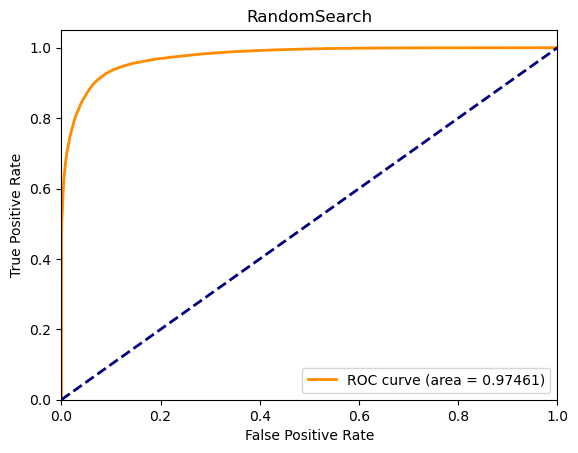

In [42]:
# Obtain cross-validated predicted class labels
y_pred_cv_random = cross_val_predict(best_rf_random, X_train_ros, y_train_ros, cv=5)

# Initialize an array to store predicted probabilities
y_pred_proba_cv_random = np.zeros_like(y_pred_cv_random, dtype=float)

# Calculate probabilities manually
for train_index, test_index in skf.split(X_train_ros, y_train_ros):
    X_train_fold, X_test_fold = X_train_ros.iloc[train_index], X_train_ros.iloc[test_index]
    y_train_fold, y_test_fold = y_train_ros.iloc[train_index], y_train_ros.iloc[test_index]
    
    clf = RandomForestClassifier(**best_params_random, random_state=42)
    clf.fit(X_train_fold, y_train_fold)
    
    probas = clf.predict_proba(X_test_fold)
    y_pred_proba_cv_random[test_index] = probas[:, 1]  # Store probabilities for the positive class

# Plot ROC curve
plot_random = plot_roc_curve(y_train_ros, y_pred_proba_cv_random, title='RandomSearch')
plot_random

### 12.4 GridSearchCV

In [43]:
'''# Initialize the RandomForestClassifier with the best parameters
best_params_grid = {'n_estimators': 200,
                    'max_features':None,
                    'min_samples_leaf': 1
                    }

best_rf_grid = RandomForestClassifier(**best_params_grid, random_state=42)

# Train the model on the training data
best_rf_grid.fit(X_train_ros, y_train_ros)

y_pred_val_grid = best_rf_grid.predict(X_val)
accuracy_val_grid = accuracy_score(y_val, y_pred_val_grid)

# Evaluate the final model on the validation set
y_pred_proba_val_grid = best_rf_grid.predict_proba(X_val)[:, 1]
roc_auc_val_grid = roc_auc_score(y_val, y_pred_val_grid)

# Print the accuracy and ROC-AUC score
print("Grid Search:")
print("Best Accuracy:", accuracy_val_grid)
print("Best ROC-AUC Score:", roc_auc_val_grid)

plot_grid = plot_roc_curve(y_val, y_pred_val_grid, title='Grid Search Optimization')
plot_grid'''

'# Initialize the RandomForestClassifier with the best parameters\nbest_params_grid = {\'n_estimators\': 200,\n                    \'max_features\':None,\n                    \'min_samples_leaf\': 1\n                    }\n\nbest_rf_grid = RandomForestClassifier(**best_params_grid, random_state=42)\n\n# Train the model on the training data\nbest_rf_grid.fit(X_train_ros, y_train_ros)\n\ny_pred_val_grid = best_rf_grid.predict(X_val)\naccuracy_val_grid = accuracy_score(y_val, y_pred_val_grid)\n\n# Evaluate the final model on the validation set\ny_pred_proba_val_grid = best_rf_grid.predict_proba(X_val)[:, 1]\nroc_auc_val_grid = roc_auc_score(y_val, y_pred_val_grid)\n\n# Print the accuracy and ROC-AUC score\nprint("Grid Search:")\nprint("Best Accuracy:", accuracy_val_grid)\nprint("Best ROC-AUC Score:", roc_auc_val_grid)\n\nplot_grid = plot_roc_curve(y_val, y_pred_val_grid, title=\'Grid Search Optimization\')\nplot_grid'

In [44]:
best_params_grid = {'n_estimators': 200,
                    'max_features': None,
                    'min_samples_leaf': 1
                    }

best_rf_grid = RandomForestClassifier(**best_params_grid, random_state=42)

# Train the model on the training data
best_rf_grid.fit(X_train_ros, y_train_ros)

# Evaluate the model using cross-validation
accuracy_scores_grid = cross_val_score(best_rf_grid, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
roc_auc_scores_grid = cross_val_score(best_rf_grid, X_train_ros, y_train_ros, cv=5, scoring='roc_auc')

print('GridSearch:')
print('Accuracy: ', np.mean(accuracy_scores_grid))
print('ROC-AUC: ', np.mean(roc_auc_scores_grid))

GridSearch:
Accuracy:  0.9197269308044296
ROC-AUC:  0.9783697943602437


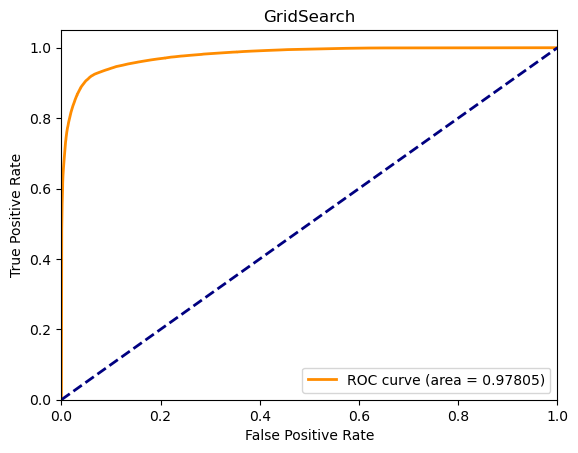

In [46]:
# Obtain cross-validated predicted class labels
y_pred_cv_grid = cross_val_predict(best_rf_grid, X_train_ros, y_train_ros, cv=5)

# Initialize an array to store predicted probabilities
y_pred_proba_cv_grid = np.zeros_like(y_pred_cv_grid, dtype=float)

# Calculate probabilities manually
for train_index, test_index in skf.split(X_train_ros, y_train_ros):
    X_train_fold, X_test_fold = X_train_ros.iloc[train_index], X_train_ros.iloc[test_index]
    y_train_fold, y_test_fold = y_train_ros.iloc[train_index], y_train_ros.iloc[test_index]
    
    clf = RandomForestClassifier(**best_params_grid, random_state=42)
    clf.fit(X_train_fold, y_train_fold)
    
    probas = clf.predict_proba(X_test_fold)
    y_pred_proba_cv_grid[test_index] = probas[:, 1]  # Store probabilities for the positive class

# Plot ROC curve
plot_grid = plot_roc_curve(y_train_ros, y_pred_proba_cv_grid, title='GridSearch')
plot_grid

#### Best model

In [47]:
all_roc_auc_scores = [roc_auc_scores_grid, roc_auc_scores_random, roc_auc_scores_tpe, roc_auc_scores_bayes]

max_roc_auc = max([max(scores) for scores in all_roc_auc_scores])

# Create a list of model names
model_names = ['Grid Search', 'Random Search', 'TPE Optimization', 'Bayesian Optimization']

# Combine the model names and their corresponding ROC AUC scores into tuples
model_scores = list(zip(model_names, all_roc_auc_scores))

# Find the index of the maximum ROC AUC score
max_index = max(range(len(model_scores)), key=lambda i: max(model_scores[i][1]))

# Get the name of the model with the maximum ROC AUC score
best_model_name = model_scores[max_index][0]
best_roc_auc = model_scores[max_index][1]

print("Best model:", best_model_name)
print("Maximum ROC AUC score:", max_roc_auc)

Best model: Grid Search
Maximum ROC AUC score: 0.9940770373599654


## 13. MLflow Log

In [48]:
import mlflow.sklearn

In [49]:
def log_mlflow_results(method_name, best_params, accuracy, roc_auc, y_val, y_pred_proba):
    """
    Log MLflow results including metrics, parameters, and plots.

    Parameters:
    - method_name: str, name of the optimization method
    - best_params: dict, best hyperparameters found by the optimization method
    - accuracy: float, accuracy score
    - roc_auc: float, ROC-AUC score
    - y_val: array-like, true labels of the validation set
    - y_pred_proba: array-like, predicted probabilities of positive class on the validation set

    Returns:
    - None
    """
    # Start MLflow run
    with mlflow.start_run():
        # Log parameters
        mlflow.log_params(best_params)

        # Log metrics
        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('roc_auc', roc_auc)

        # Log plot
        plot_roc_curve(y_val, y_pred_proba, title=f'{method_name} ROC Curve')
        plt.savefig(f'{method_name}_ROC_Curve.png')
        mlflow.log_artifact(f'{method_name}_ROC_Curve.png')

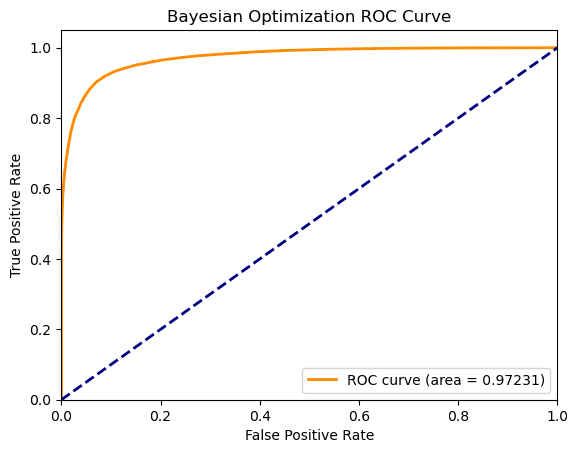

<Figure size 640x480 with 0 Axes>

In [50]:
log_mlflow_results('Bayesian Optimization', best_params_bayesian, np.mean(accuracy_scores_bayes), np.mean(roc_auc_scores_bayes), y_train_ros, y_pred_proba_cv_bayes)

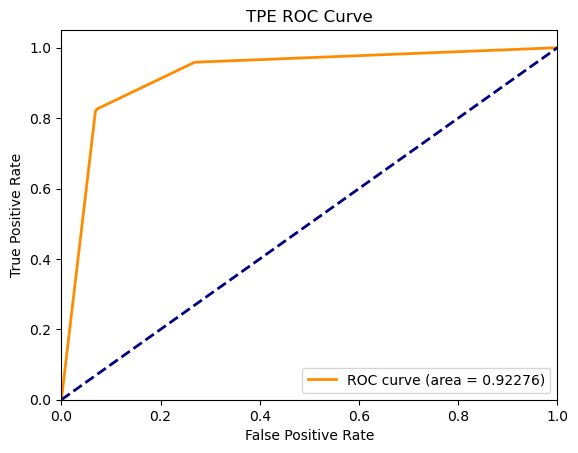

<Figure size 640x480 with 0 Axes>

In [51]:
log_mlflow_results('TPE', best_params_tpe, np.mean(accuracy_scores_tpe), np.mean(roc_auc_scores_tpe), y_train_ros, y_pred_proba_cv_tpe)

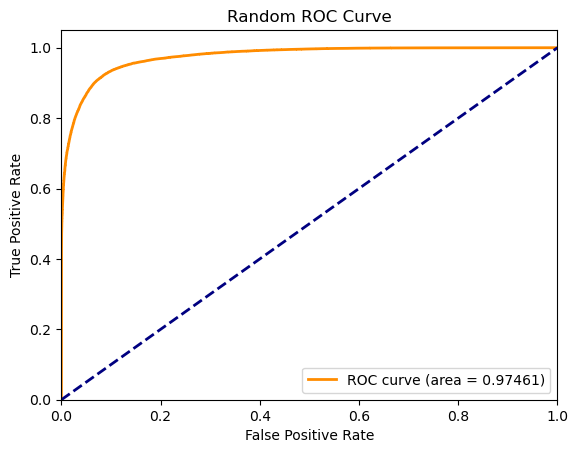

<Figure size 640x480 with 0 Axes>

In [52]:
log_mlflow_results('Random', best_params_random, np.mean(accuracy_scores_random), np.mean(roc_auc_scores_random), y_train_ros, y_pred_proba_cv_random)

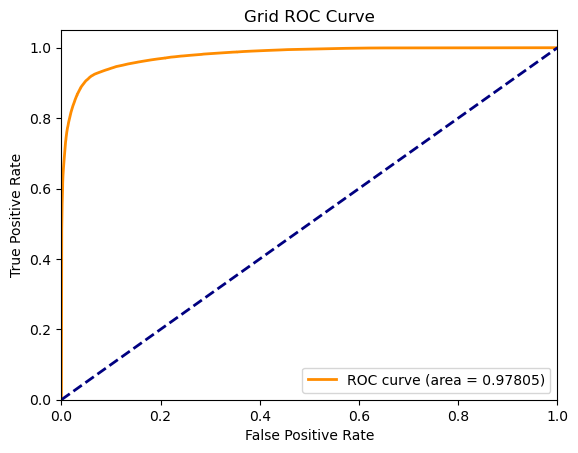

<Figure size 640x480 with 0 Axes>

In [53]:
log_mlflow_results('Grid', best_params_grid, np.mean(accuracy_scores_grid), np.mean(roc_auc_scores_grid), y_train_ros, y_pred_proba_cv_grid)